## Обучаем модель CBoW

В этом примере мы рассмотрим обучение языковой модели CBoW, чтобы получить собственное пространство эмбеддингов Word2Vec. Мы будем использовать набор данных AG News в качестве датасета.

In [21]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

Начнем с загрузки датасета:

In [22]:
ds_train, ds_test = tfds.load('ag_news_subset').values()


## Модель CBoW
CBoW учится предсказывать слово на основе соседних слов из окна размером $N$. Например, когда $N=1$, мы получим следующие пары из предложения *I like to train networks*: (like,I), (I, like), (to, like), (like,to), (train,to), (to, train), (networks, train), (train,networks, networks). Здесь первое слово — это соседнее слово, используемое в качестве входных данных, а второе слово — это то, которое мы предсказываем.

Чтобы построить сеть для прогнозирования следующего слова, нам нужно будет указать соседнее слово в качестве входных данных и получить номер слова в качестве выхода. Архитектура сети CBoW следующая:

* Входное слово передается на слой эмбеддинга. Этот слой и будет нашим Word2Vec-эмбеддингом, поэтому мы определим его отдельно как переменную 'embedder'. В этом примере мы будем использовать размер size = 30, хотя вы можете поэкспериментировать с более высокими размерностями (реальный word2vec имеет размерность вектора 300)

* Эмбеддинг-вектор передаётся на полносвязный слой, который будет предсказывать выходное слово. Таким образом, он имеет выходную размерность `vocab_size`.

Слой `Embedding` в Keras принимает на вход номера слов в словаре, а не one-hot-encoding вектора. Мы указываем `input_length=1`, поскольку нам нужно только одно слово во входной последовательности (хотя на практике обычно используют чуть более длинное окно).

Для выходных данных мы используем `sparse_categorical_crossentropy` в качестве функции потерь, также подавая на выход сети номер слова в словаре.

Мы установим размер `vocab_size=5000` чтобы немного ограничить вычисления.

In [23]:
vocab_size = 5000

vectorizer = keras.layers.TextVectorization(max_tokens=vocab_size,input_shape=(1,))
embedder = keras.layers.Embedding(vocab_size,30,input_length=1)

model = keras.Sequential([
    embedder,
    keras.layers.Dense(vocab_size,activation='softmax')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1, 30)             150000    
                                                                 
 dense_2 (Dense)             (None, 1, 5000)           155000    
                                                                 
Total params: 305000 (1.16 MB)
Trainable params: 305000 (1.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Инициализируем векторизатор и запомним словарь:

In [24]:
def extract_text(x):
    return x['title']+' '+x['description']

vectorizer.adapt(ds_train.take(500).map(extract_text))
vocab = vectorizer.get_vocabulary()

## Подготовка обучающих данных

Теперь давайте запрограммируем основную функцию, которая будет получать пары слов CBoW из текста. Эта функция позволит нам указать размер окна, и вернет набор пар - входное и выходное слово. Обратите внимание, что эта функция может быть использована как на словах, так и на векторах/тензорах - что позволит нам закодировать текст, прежде чем передать его в функцию `to_cbow`.

In [25]:
def to_cbow(sent,window_size=2):
    res = []
    for i,x in enumerate(sent):
        for j in range(max(0,i-window_size),min(i+window_size+1,len(sent))):
            if i!=j:
                res.append([sent[j],x])
    return res

print(to_cbow(['I','like','to','train','networks']))
print(to_cbow(vectorizer('I like to train networks')))

[['like', 'I'], ['to', 'I'], ['I', 'like'], ['to', 'like'], ['train', 'like'], ['I', 'to'], ['like', 'to'], ['train', 'to'], ['networks', 'to'], ['like', 'train'], ['to', 'train'], ['networks', 'train'], ['to', 'networks'], ['train', 'networks']]
[[<tf.Tensor: shape=(), dtype=int64, numpy=232>, <tf.Tensor: shape=(), dtype=int64, numpy=112>], [<tf.Tensor: shape=(), dtype=int64, numpy=3>, <tf.Tensor: shape=(), dtype=int64, numpy=112>], [<tf.Tensor: shape=(), dtype=int64, numpy=112>, <tf.Tensor: shape=(), dtype=int64, numpy=232>], [<tf.Tensor: shape=(), dtype=int64, numpy=3>, <tf.Tensor: shape=(), dtype=int64, numpy=232>], [<tf.Tensor: shape=(), dtype=int64, numpy=1388>, <tf.Tensor: shape=(), dtype=int64, numpy=232>], [<tf.Tensor: shape=(), dtype=int64, numpy=112>, <tf.Tensor: shape=(), dtype=int64, numpy=3>], [<tf.Tensor: shape=(), dtype=int64, numpy=232>, <tf.Tensor: shape=(), dtype=int64, numpy=3>], [<tf.Tensor: shape=(), dtype=int64, numpy=1388>, <tf.Tensor: shape=(), dtype=int64, num

Подготовим обучающий набор данных. Мы пройдёмся по всем новостям, вызове `to_cbow`, чтобы получить список пар слов, и добавим эти пары к `X` и `Y`. Ради экономии времени мы рассмотрим только первые 10k новостей - вы можете легко снять ограничение, если у вас есть больше времени на ожидание, и вы хотите получить более качественные результаты.

In [8]:
from tqdm import tqdm

X = []
Y = []
for x in tqdm(ds_train.take(10000).map(extract_text)):
  for w1,w2 in to_cbow(vectorizer(x),window_size=1):
    X.append(w1)
    Y.append(w2)

X = np.expand_dims(np.array(X),1)
Y = np.expand_dims(np.array(Y),1)

100%|██████████| 10000/10000 [08:35<00:00, 19.38it/s]


Теперь займёмся обучением. Мы будем использовать оптимизатор SGD с довольно высокой скоростью обучения. Вы также можете попробовать поиграть с другими оптимизаторами, такими как Adam. Вы вы можете повторно запустить эту ячейку, если хотите получить более качественную модель.

In [34]:
model.compile(optimizer=keras.optimizers.SGD(lr=0.1),loss='sparse_categorical_crossentropy')
model.fit(X,Y,epochs=100,batch_size=512)

Epoch 1/100
1422/1422 [==============================] - 14s 9ms/step - loss: 8.1571
Epoch 2/100
1422/1422 [==============================] - 6s 4ms/step - loss: 7.4735
Epoch 3/100
1422/1422 [==============================] - 5s 4ms/step - loss: 7.0606
Epoch 4/100
1422/1422 [==============================] - 6s 4ms/step - loss: 6.9421
Epoch 5/100
1422/1422 [==============================] - 6s 4ms/step - loss: 6.8626
Epoch 6/100
1422/1422 [==============================] - 6s 4ms/step - loss: 6.7856
Epoch 7/100
1422/1422 [==============================] - 5s 4ms/step - loss: 6.7118
Epoch 8/100
1422/1422 [==============================] - 5s 4ms/step - loss: 6.6435
Epoch 9/100
1422/1422 [==============================] - 6s 4ms/step - loss: 6.5827
Epoch 10/100
1422/1422 [==============================] - 5s 4ms/step - loss: 6.5291
Epoch 11/100
1422/1422 [==============================] - 6s 4ms/step - loss: 6.4825
Epoch 12/100
1422/1422 [==============================] - 5s 4ms/step - l

## Экспериментируем с Word2Vec

Чтобы использовать Word2Vec, давайте извлечем эмбеддинг-векторы, соответствующие всем словам в нашем словаре:

In [38]:
vectors = embedder(vectorizer(vocab))
vectors = tf.reshape(vectors,(-1,30)) # избавляемся от лишней размерности
vectors.shape

TensorShape([5000, 30])

In [39]:
embedder.weights

[<tf.Variable 'embedding_2/embeddings:0' shape=(5000, 30) dtype=float32, numpy=
 array([[ 1.5263710e-02,  5.5849068e-03, -2.5809204e-02, ...,
          7.2865263e-03, -3.3647656e-02, -1.6866229e-02],
        [ 7.9031169e-01,  1.0370319e+00,  2.0999508e+00, ...,
         -1.6227142e+00,  1.0335129e+00, -1.0554715e+00],
        [-2.0682469e-01,  6.4807159e-01,  1.0311967e+00, ...,
         -7.4837762e-01,  6.3116896e-01, -1.4462180e+00],
        ...,
        [-3.0499231e-04, -2.6846724e-02, -2.4885751e-02, ...,
          4.2770345e-02,  3.8139977e-02, -4.1736383e-02],
        [ 1.9423632e-02,  1.4048339e-02, -5.0181445e-02, ...,
          2.6467362e-02,  3.8531303e-02, -1.3911292e-02],
        [-3.3912461e-02, -1.9125190e-02,  6.1237145e-02, ...,
          2.0190418e-02, -1.3452798e-02, -4.7883082e-02]], dtype=float32)>]

Давайте посмотрим, например, как слово **wednesday** кодируется в вектор:

In [40]:
paris_vec = embedder(vectorizer('wednesday'))[0]
print(paris_vec)

tf.Tensor(
[-0.02354188 -0.02039314 -0.02771657 -0.11275668 -0.00067338 -0.06579518
  0.07753289 -0.09967647 -0.04042403 -0.09526078 -0.01851155 -0.15009068
 -0.13635948  0.06379286 -0.11217481 -0.03195835  0.02636432 -0.11276939
 -0.072924    0.09409001 -0.02485    -0.12108654  0.09259735  0.08940504
 -0.01149343 -0.05585231 -0.20390698 -0.08074458  0.01979482 -0.05611552], shape=(30,), dtype=float32)


In [41]:
vectors[int(vectorizer('wednesday'))]

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([-0.02354188, -0.02039314, -0.02771657, -0.11275668, -0.00067338,
       -0.06579518,  0.07753289, -0.09967647, -0.04042403, -0.09526078,
       -0.01851155, -0.15009068, -0.13635948,  0.06379286, -0.11217481,
       -0.03195835,  0.02636432, -0.11276939, -0.072924  ,  0.09409001,
       -0.02485   , -0.12108654,  0.09259735,  0.08940504, -0.01149343,
       -0.05585231, -0.20390698, -0.08074458,  0.01979482, -0.05611552],
      dtype=float32)>

Интересно использовать Word2Vec для поиска синонимов. Следующая функция вернет `n` ближайших слов к заданному входному слову. Чтобы найти их, вычисляем норму $|w_i - v|$, где $v$ - вектор, соответствующий нашему входному слову, а $w_i$ - кодировка $i$-го слова в словаре. Затем мы сортируем массив и возвращаем соответствующие индексы, используя `argsort`, и берем первые `n` элементов списка, которые кодируют позиции ближайших слов в словаре.  

In [65]:
def close_words(x,n=5):
  vec = embedder(vectorizer(x))[0]
  top5 = np.linalg.norm(vectors-vec,axis=1).argsort()[:n]
  return [ vocab[x] for x in top5 ]

close_words('wednesday')

['wednesday', 'monday', 'thursday', 'friday', 'tuesday']

In [66]:
close_words('in')

['in', 'of', 'on', 'for', 'to']

In [67]:
close_words('government')

['government', 'australian', 'european', 'national', 'best']

Попробуем визуализировать эмбеддинги слов, применив метод понижения размерности:

In [68]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
x2_pca = PCA(n_components=2).fit_transform(vectors)
# x2_tsne = TSNE(n_components=2).fit_transform(vectors)

Для наглядности будем брать только первые 500 слов из словаря:

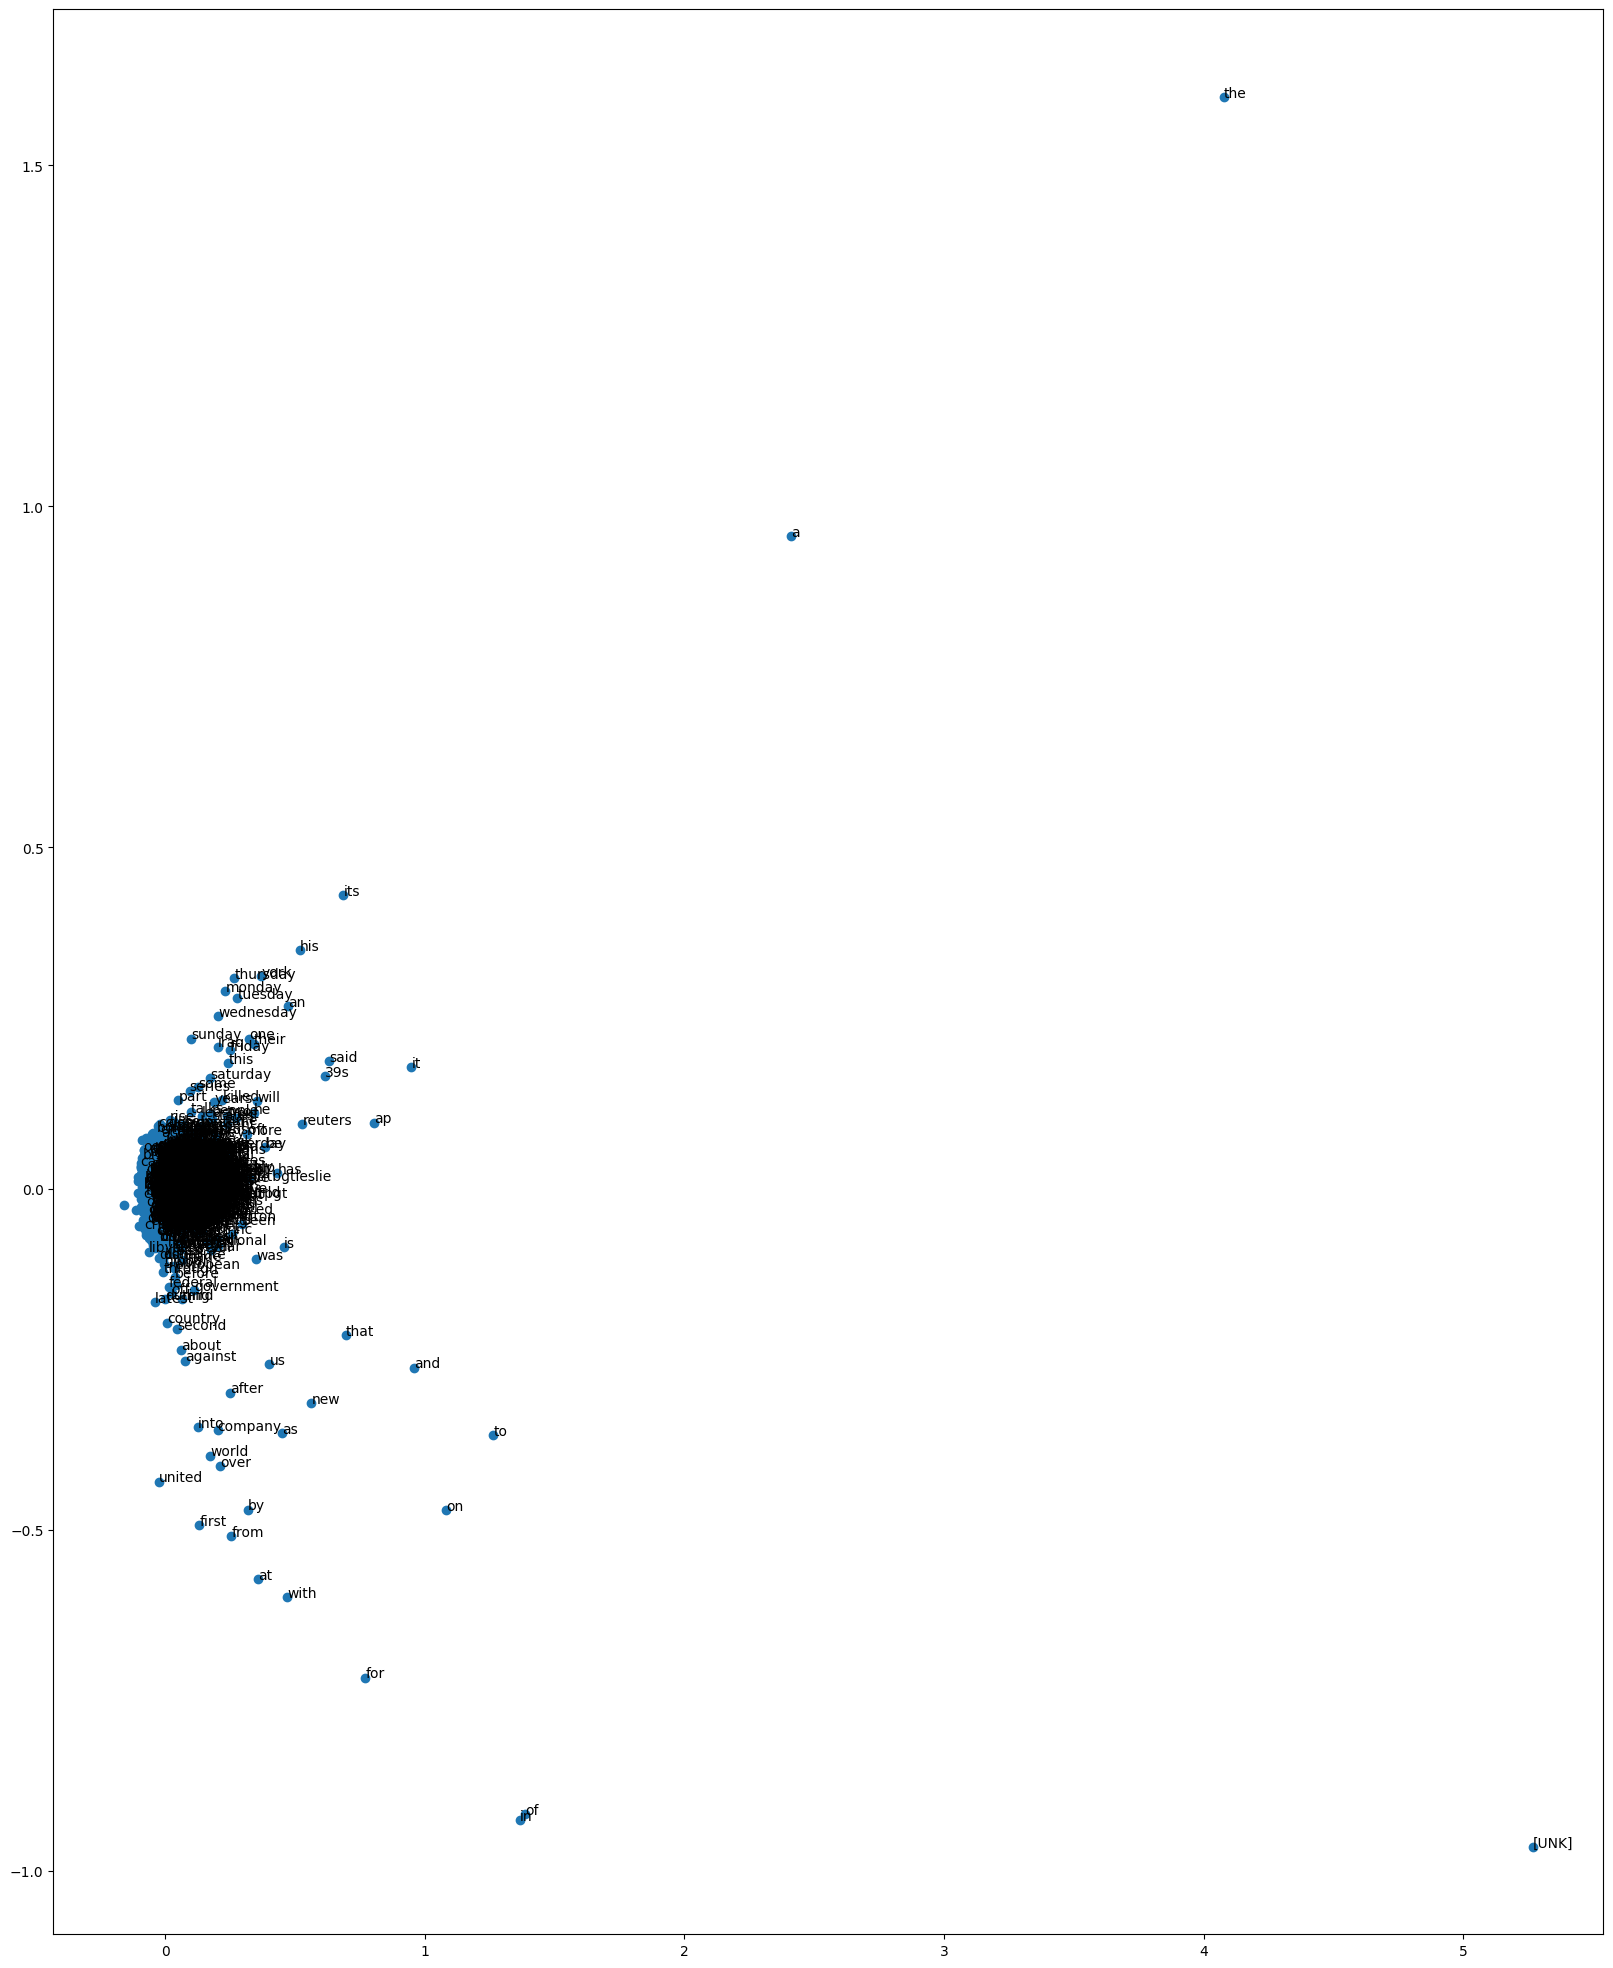

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,25))
plt.scatter(x2_pca[:,0],x2_pca[:,1])
for w, c in zip(vocab[:500],x2_pca):
    plt.annotate(w,c)
for w, c in zip(vocab[::-1][:500],x2_pca[::-1]):
    plt.annotate(w,c)

## Упражнение

С помощью такого же метода, обучите эмбеддинги размерности 2. Это позволит вам визуализировать эмбеддинги слов без понижения размерности. Сравните результаты с приведённым выше графиком.

## Выводы

Используя методы обучения без учителя для построения эмдеббингов, мы можем обучить модель Word2Vec на произвольном тексте без необходимости ручной разметки.